# Predicting Price Of Renting An Apartment In Lagos State.

The objective of this project is predicting the cost of renting an apartment in lagos state based on the area, number of bed rooms and number of toilets.
Data set for this project was gathered from https://tolet.ng, also scrapper for gathered the data can be found on my github here -> https://github.com/victorlenerd/toletngscrapper.

## Loading And Cleaning Data.

In [18]:
## Loading Data
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as sm
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
import math

sns.set_style("whitegrid")

%matplotlib inline

In [19]:
data = pd.read_json('./data.json')
data.reset_index()
data.tail()

,area,no_bath,no_bed,no_toilets,price
9835,ogba lagos,2,2,3,500000.0
9836,- ogba lagos,0,3,0,1500000.0
9837,- ikeja lagos,0,3,0,1800000.0
9838,chief native street surulere lagos,2,2,3,1000000.0
9839,orile agege close agege lagos,3,3,3,700000.0


In [20]:
# The scrapper gathered some wrong values from dom elements that had the same property. It's best to drop them
data = data.dropna()
data = data.drop_duplicates()

In [21]:
data.tail()

,area,no_bath,no_bed,no_toilets,price
9834,"iyana ipaja , ipaja lagos",3,3,3,650000.0
9835,ogba lagos,2,2,3,500000.0
9837,- ikeja lagos,0,3,0,1800000.0
9838,chief native street surulere lagos,2,2,3,1000000.0
9839,orile agege close agege lagos,3,3,3,700000.0


### Data From Nigerian Property Centre

In [22]:
data2 = pd.read_json('./data.npc.json')
data2.reset_index()
data2.tail()

,area,no_bath,no_bed,no_parking_spaces,no_toilets,price
7475,"Victoria Gardens City, VGC, Lekki, Lagos",4,3,2,4,2000000.0
7476,"Phase 1, Lekki, Lagos",2,1,2,2,1300000.0
7477,"Agungi, Lekki, Lagos",,2,,,NaN
7478,"Ogba, Ogba, Ikeja, Lagos",,1,,,200000.0
7479,"Fadare Street, Ogba, Ikeja, Lagos",2,3,,3,600000.0


In [23]:
# The scrapper gathered some wrong values from dom elements that had the same property. It's best to drop them
data2 = data2.dropna()
data2 = data2.drop_duplicates()

In [24]:
data2.tail()

,area,no_bath,no_bed,no_parking_spaces,no_toilets,price
7473,"Adeyeri Crescent Estate, Ogba, Ikeja, Lagos",3,3,,4,700000.0
7475,"Victoria Gardens City, VGC, Lekki, Lagos",4,3,2,4,2000000.0
7476,"Phase 1, Lekki, Lagos",2,1,2,2,1300000.0
7478,"Ogba, Ogba, Ikeja, Lagos",,1,,,200000.0
7479,"Fadare Street, Ogba, Ikeja, Lagos",2,3,,3,600000.0


In [28]:
df = pd.concat([data, data2])

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14208 entries, 0 to 7479
Data columns (total 6 columns):
area                 14208 non-null object
no_bath              14208 non-null object
no_bed               14208 non-null object
no_parking_spaces    6215 non-null object
no_toilets           14208 non-null object
price                14208 non-null float64
dtypes: float64(1), object(5)
memory usage: 777.0+ KB


### Using areas.json to make area property more structured, by converting address to area.

In [32]:
## Loading Areas
areas = pd.read_json('./areas.json')

In [33]:
areas_dict = areas.to_dict()
areas_list = []

for key, value in areas_dict[0].items():
    areas_list.append(value)
    
print(areas_list)

[u'Abule Egba', u'Agege', u'Ajah', u'Ajaokuta', u'Alimosho', u'Amuwo Odofin', u'Apapa', u'Arepo', u'Badagry', u'Egbe Idimu', u'Egbeda', u'Ejigbo', u'Epe', u'Gbagada', u'Ibeju Lekki', u'Iju', u'Ikeja', u'Ikorodu', u'Ikotun Igando', u'Ikoyi', u'Ilaje', u'Ilupeju', u'Ipaja', u'Isolo', u'Ketu', u'Kosofe Ikosi', u'Lagos Island', u'Lekki', u'Maryland', u'Mushin', u'Ogba', u'Ogudu', u'Ojo', u'Ojodu', u'Ojota', u'Okota', u'Orile', u'Oshodi', u'Sangotedo', u'Shagari', u'Shomolu', u'Surulere', u'Victoria Island', u'Yaba']


In [34]:
def addressToArea(address):
    
    address = address.replace(',', '')
    address = address.replace('-', '')
    address = address.replace('/', ' ')
    
    for area in areas_list:
        if area.lower() in address.lower():
            return area
    
    # Fix bad addresses
    
    if 'greenville' in address.lower():
        return 'Ajah'
    
    if  'southen' in address.lower() or 'oral' in address.lower() or 'crest' in address.lower() or 'osborne' in address.lower() or 'agungi' in address.lower() or  'lekky' in address.lower() or 'admiralty' in address.lower() or 'ikota' in address.lower() or 'ikate' in address.lower() or 'chevron' in address.lower() or 'chevy' in address.lower() or 'shoprite' in address.lower() or 'osapa' in address.lower() or 'parkview' in address.lower():
        return 'Lekki'
    
    if 'mende'in address.lower() or 'aladura' in address.lower() or 'olatunde sanni'  in address.lower():
        return 'Maryland'

    if 'alakuko' in address.lower() or 'saji ayangade' in address.lower():
        return 'Ikeja'
    
    if 'ishaga' in address.lower():
        return 'Isolo'

    if 'oniru' in address.lower() or 'banana island' in address.lower():
        return 'Ikoyi'
    
    if 'alaka' in address.lower() or 'adekunle' in address.lower() or 'james island' in address.lower():
        return 'Surulere'
    
    if 'block d5' in address.lower():
        return 'Victoria Island'
    
    print ('Cound not find address', address)
    return address

In [35]:
df['area'] = df['area'].apply(addressToArea)

('Cound not find address', u'power line road lagos')
('Cound not find address', u'greenland estate lagos')
('Cound not find address', u'olokonla lagos')
('Cound not find address', u'olokonla lagos')
('Cound not find address', u'agunigi lagos')
('Cound not find address', u'agunigi lagos')
('Cound not find address', u'agunigi lagos')
('Cound not find address', u'idi araba lagos')
('Cound not find address', u'magodo lagos')
('Cound not find address', u'omole phase 1 lagos')
('Cound not find address', u'magodo lagos')
('Cound not find address', u'1004 estate lagos')
('Cound not find address', u'bello street off onimeran palace way meiran lagos')
('Cound not find address', u'igbo efon beside etiosa local govt secretariat lagos')
('Cound not find address', u'illason opposite lkate lagos')
('Cound not find address', u'illason opposite lkate lagos')
('Cound not find address', u'off adelabu lagos')
('Cound not find address', u'ebutte metta lagos')
('Cound not find address', u'off nnobi kilo lag

In [36]:
# Remove entries with less than one bed rooms
data = data[data['no_bed'] > 1]

In [37]:
data.describe()

,price
count,7.993000e+03
mean,1.740838e+06
std,5.936164e+06
min,1.000000e-02
25%,4.500000e+05
50%,7.500000e+05
75%,1.500000e+06
max,3.500000e+08


### Visualizing Data

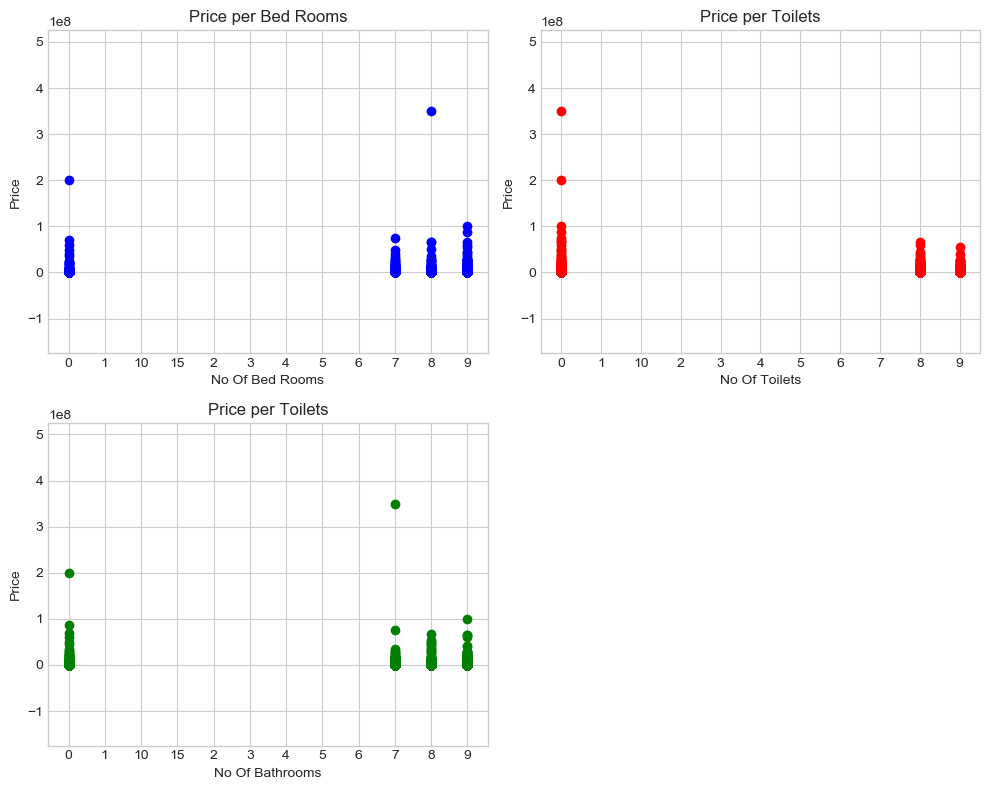

In [52]:
plt.figure(figsize=(10,8))

low = np.min(data['price'])
high = np.max(data['price'])

plt.subplot(2, 2, 1)
plt.scatter(data['no_bed'], data['price'], color='blue')
plt.title('Price per Bed Rooms')
plt.xlabel('No Of Bed Rooms')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.subplot(2, 2, 2)
plt.scatter(data['no_toilets'], data['price'], color='red')
plt.title('Price per Toilets')
plt.xlabel('No Of Toilets')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.subplot(2, 2, 3)
plt.scatter(data['no_bath'], data['price'], color='green')
plt.title('Price per Toilets')
plt.xlabel('No Of Bathrooms')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.tight_layout()
plt.show()

(-1999999998.0, 6000000000.0)

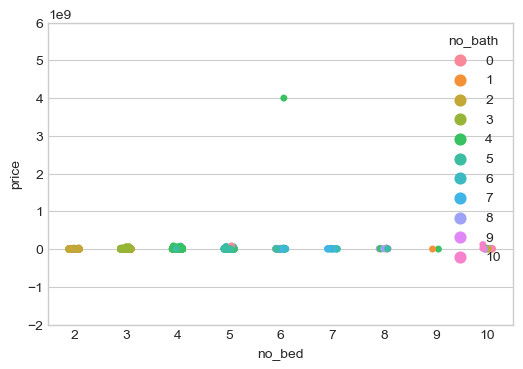

In [20]:
low = np.min(data['price'])
high = np.max(data['price'])
sp = sns.stripplot(x=data["no_bed"], y=data["price"], jitter=True, hue=data["no_bath"])
sp.set_ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

### Dealing with ouliers

Some entries in the data are hostels, office spaces and shops. They have to be removed because this project is only focused on apartments.

In [43]:
less_than_one_bed = data[data['no_bath'] < 6]
less_than_one_bed

,area,no_bath,no_bed,no_toilets,price
0,2,3,3,4,1200000.0
6,26,5,5,5,4000000.0
8,21,2,2,0,200000.0
9,21,3,3,0,5500000.0
10,38,3,3,4,18000000.0
11,38,1,3,2,50000.0
12,2,3,3,4,550000.0
13,2,3,3,4,1500000.0
14,38,4,4,5,6000000.0
15,38,3,3,4,5000000.0


### Convert Area To Numerical Values

In [13]:
encoder = LabelEncoder()
housing_areas = data['area']
housing_area_endcoded = encoder.fit_transform(housing_areas)
data['area'] = housing_area_endcoded

In [14]:
encoder.classes_

array([u'Abule Egba', u'Agege', u'Ajah', u'Ajaokuta', u'Alimosho',
       u'Amuwo Odofin', u'Apapa', u'Arepo', u'Badagry', u'Egbe Idimu',
       u'Ejigbo', u'Epe', u'Gbagada', u'Ibeju Lekki', u'Iju', u'Ikeja',
       u'Ikorodu', u'Ikotun Igando', u'Ikoyi', u'Ilaje', u'Ilupeju',
       u'Ipaja', u'Isolo', u'Ketu', u'Kosofe Ikosi', u'Lagos Island',
       u'Lekki', u'Maryland', u'Mushin', u'Ogba', u'Ogudu', u'Ojo',
       u'Okota', u'Orile', u'Oshodi', u'Sangotedo', u'Shomolu',
       u'Surulere', u'Victoria Island', u'Yaba'], dtype=object)

In [15]:
data.head()

,area,no_bath,no_bed,no_toilets,price
0,2,3,3,4,1200000.0
6,26,5,5,5,4000000.0
8,21,2,2,0,200000.0
9,21,3,3,0,5500000.0
10,38,3,3,4,18000000.0


# Model Development

The accuracy of the model used would be measured using: 
   * **Mean Squared Error**: This is the average of the squares of the errors of all the datapoints in the given dataset.
   * **Explained Variance Score**: This score measures how well our model can account for the variation in our dataset.
   * **R2-score**: This tells us how well the unknown samples will be predicted by our model.

In [21]:
def accuracy(test, pred):
    print("Mean Squared Error: ", round(sm.mean_squared_error(test, pred), 2))
    print("Explained Variance Score: ", round(sm.explained_variance_score(test, pred),2))
    print("R2-score: ", round(sm.r2_score(test, pred), 2))

## Spliting data for train and test

In [23]:
price = pd.Series(data['price'], dtype='float32')
feature_final = data.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feature_final,
                                                    price,
                                                   test_size = 0.2,
                                                   random_state = 0)

In [24]:
print("Training set has {} samples.", X_train.shape)
print("Testing set has {} samples.", y_train.shape)

Training set has {} samples. (4692, 4)
Testing set has {} samples. (4692,)


### Base Model Performance

In [25]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
y_train_pred = linear_regressor.predict(X_test)

NameError: name 'linear_regressor' is not defined

In [27]:
accuracy(y_train, y_train_pred)

Mean Squared Error:  3.41036835367e+15
Explained Variance Score:  0.01
R2-score:  0.01
